#**Resumen de cuestionario en topicos para twitter**



## Importamos librerías

In [1]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import tokenize
import numpy as np

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
! pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=2dc25421622970285eeee7c3d6be5ffeb9acb44f5340b2588ff37072ea14c6ee
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import re
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt



# Conecto con drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path='drive/My Drive/Proyecto_BD_coders/Dataset/'
path_rdo='drive/My Drive/keepcoding/Tweets/resultados/'

# Importo preguntas cuestionario

In [6]:
path+'Columnas_Descripcion.csv'

'drive/My Drive/Proyecto_BD_coders/Dataset/Columnas_Descripcion.csv'

In [7]:
questions=pd.read_csv(path+'Columnas_Descripcion.csv', header=None, sep=';',usecols=[0, 1],names=['key','question'])
questions.head()

,key,question
0,CNTRYID,Country Identifier
1,CNT,Country code 3-character
2,CNTSCHID,Intl. School ID
3,CNTSTUID,Intl. Student ID
4,CYC,PISA Assessment Cycle (2 digits + 2 character ...


In [8]:
df_clean=pd.read_csv(path+'df_clean.csv')


In [9]:
questions_clean=df_clean.columns
questions_clean=questions_clean[2:-1]
questions_clean

Index(['CNTRYID', 'CNTSCHID', 'CNTSTUID', 'NatCen', 'SUBNATIO', 'OECD',
       'ADMINMODE', 'LANGTEST_QQQ', 'LANGTEST_COG', 'BOOKID',
       ...
       'PV2RTML', 'PV3RTML', 'PV4RTML', 'PV5RTML', 'PV6RTML', 'PV7RTML',
       'PV8RTML', 'PV9RTML', 'PV10RTML', 'SENWT'],
      dtype='object', length=692)

In [10]:
# me quedo con las claves y las preguntas que han pasado el filtro de la limpieza de datos, las que se corresponden con df_clean
df=questions[questions['key'].isin(questions_clean)]
df.head()

,key,question
0,CNTRYID,Country Identifier
2,CNTSCHID,Intl. School ID
3,CNTSTUID,Intl. Student ID
5,NatCen,National Centre 6-digit Code
7,SUBNATIO,Adjudicated sub-region code 7-digit code (3-di...


## Limpiamos el cuestionario

Elimino los textos de preguntas que no aportan nada

In [11]:
strings = ['FINAL TRIMMED NONRESPONSE ADJUSTED STUDENT REPLICATE BRR-FAY WEIGHTS','Country Identifier','Country code 3-character',
           'Intl. School ID','Intl. Student ID',]


In [12]:
questions_erased=[]
rgx = '\\b(?:' + '|'.join(strings) + ')\\b'
questions_erased.append(df[df['question'].str.contains(rgx, regex=True, na=False)]['key'])
df_questions=df[~df['question'].str.contains(rgx, regex=True, na=False)]

In [13]:
df_questions=df_questions.drop_duplicates()

In [14]:
# Elimino de las preguntas la referencia al centro en el que estudió:  <ISCED level 6> por ejemplo
df_questions['question']=df_questions['question'].str.replace('<',' ')
df_questions['question']=df_questions['question'].str.replace('>',' ')
df_questions['question']=df_questions['question'].str.replace('ISCED',' ')
df_questions.head(5)

,key,question
5,NatCen,National Centre 6-digit Code
7,SUBNATIO,Adjudicated sub-region code 7-digit code (3-di...
8,OECD,OECD country
9,ADMINMODE,Mode of Respondent
10,LANGTEST_QQQ,Language of Questionnaire


# Clusterizo las preguntas

In [15]:
"""
Las frases se mapean en embeddings y luego se utiliza k-mean clustering
"""

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

corpus=list(df_questions['question'])
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    clustering_model = KMeans(n_clusters=k)
    clustering_model.fit(corpus_embeddings)
  
    distortions.append(sum(np.min(cdist(corpus_embeddings, clustering_model.cluster_centers_,
                                        'euclidean'), axis=1)) / corpus_embeddings.shape[0])
    inertias.append(clustering_model.inertia_)
  
    mapping1[k] = sum(np.min(cdist(corpus_embeddings, clustering_model.cluster_centers_,
                                   'euclidean'), axis=1)) / corpus_embeddings.shape[0]
    mapping2[k] = clustering_model.inertia_




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

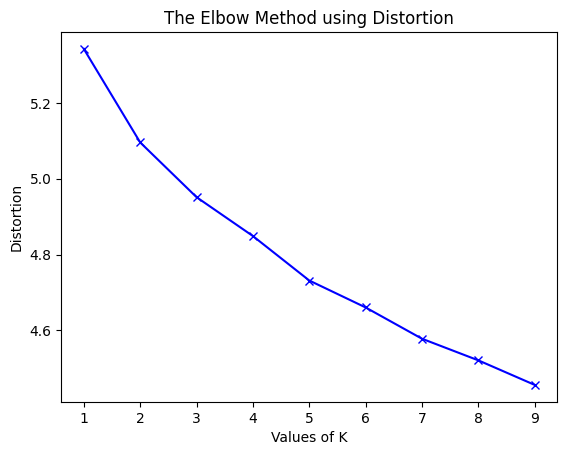

In [16]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

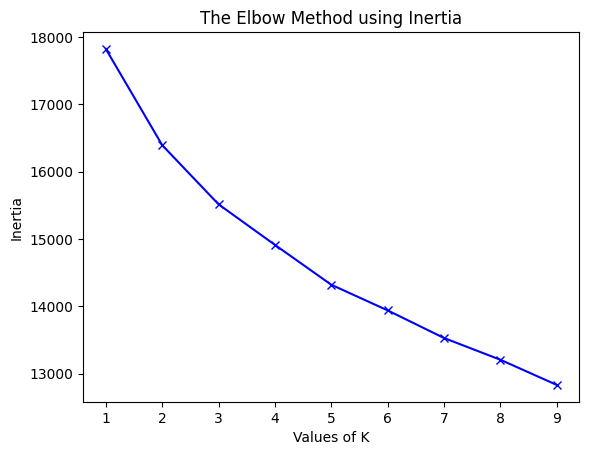

In [17]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [18]:
# selecciono el numero de clusters
num_clusters = 5

In [19]:

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

corpus=list(df_questions['question'])
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering

clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster  1
['Student International Grade (Derived)', 'Student (Standardized) Birth - Month', 'Student (Standardized) Birth -Year', 'Student (Standardized) Gender', 'What is the  highest level of schooling  completed by your mother?', 'Does your mother have this qualification?    level 6  (incl. higher qualifications at level 5A in some countries)', 'Does your mother have this qualification?    level 5A  (excl. higher qualifications at level 5A in some countries)', 'Does your mother have any of the following qualifications?    level 5B ', 'What is the  highest level of schooling  completed by your father?', 'Does your father have this qualification?    level 6  (incl. higher qualifications at level 5A in some countries)', 'Does your father have this qualification?    level 5A  (excl. higher qualifications at level 5A in some countries)', 'Does your father have any of the following qualifications?    level 5B ', 'In your home: A quiet place to study', 'In your home: Books to help with yo

# Resumo los clusters por palabras/tema para su búsqueda en twitter

In [20]:
len(stop_words)

179

In [21]:
# añado stop words propias, muchas provienen de la primera parte de la pregunta que se repite para varias preguntas y  no nos permite extraer las palabras más representativas del cluster
stop_words_custom={'school','use','using','lessons','classroom','learnt', 'heard', 'read','plausible','value','subscale','following','agree','well','...','e.g','wle','describe','get','often','teacher','test','last','12','months','10','many','education', '5a', 'highest','typical','Find','future', 'study', 'types','work',
                   'feel','Plausible', 'Value','Global', 'Competency','global', 'competency','reading','term', 'student', 'thinking', 'students'}
stop_words.update(stop_words_custom)

In [22]:
def summarize_questions(text):
  sentences = []
  for text_part in text:
    sentences.extend(tokenize.sent_tokenize(text_part))
  word_weights={}
  for sent in sentences:
    for word in word_tokenize(sent):
      word = word.lower()
      if len(word) > 1 and word not in stop_words:
        if word in word_weights.keys():
          word_weights[word] += 1
        else:
          word_weights[word] = 1
  sentence_weights={}
  for sent in sentences:
    sentence_weights[sent] = 0
    tokens = word_tokenize(sent)
    for word in tokens:  
      word = word.lower()
      if word in word_weights.keys():
        sentence_weights[sent] += word_weights[word]
      highest_weights = sorted(sentence_weights.values())[-1:]
  summary=""
  for sentence,strength in sentence_weights.items():
    if strength in highest_weights:
      print(sentence)
      summary += sentence + " "
  summary = summary.replace('_', ' ').strip()
  print(summary)
  return summary,word_weights
  


In [23]:
summary_clusters=[]
word_weights_cluster=pd.DataFrame()
clustered_sentences_df=pd.DataFrame()
for i, cluster in enumerate(clustered_sentences):
  summary, word_weights = summarize_questions(cluster)
  summary_clusters.append(summary)
  word_weights=pd.DataFrame.from_dict(word_weights,orient='index',columns=['rep']).sort_values(by='rep',ascending=False)
  word_weights['cluster']=i
  word_weights_cluster=pd.concat([word_weights_cluster,word_weights ])
  cluster=pd.DataFrame(cluster,columns=['question'])
  cluster['cluster']=i
  clustered_sentences_df=pd.concat([clustered_sentences_df,cluster])
  

Thinking of past two  test language lessons : It was clear that the teacher likes to deal with the topic of the lesson.
Thinking of past two  test language lessons : It was clear that the teacher likes to deal with the topic of the lesson.
Plausible Value 1 in Mathematics
Plausible Value 2 in Mathematics
Plausible Value 3 in Mathematics
Plausible Value 4 in Mathematics
Plausible Value 5 in Mathematics
Plausible Value 6 in Mathematics
Plausible Value 7 in Mathematics
Plausible Value 8 in Mathematics
Plausible Value 9 in Mathematics
Plausible Value 10 in Mathematics
Plausible Value 1 in Science
Plausible Value 2 in Science
Plausible Value 3 in Science
Plausible Value 4 in Science
Plausible Value 5 in Science
Plausible Value 6 in Science
Plausible Value 7 in Science
Plausible Value 8 in Science
Plausible Value 9 in Science
Plausible Value 10 in Science
Plausible Value 1 in Mathematics Plausible Value 2 in Mathematics Plausible Value 3 in Mathematics Plausible Value 4 in Mathematics Plausi

# Resumenes para búsqueda en twitter con preguntas asociadas

In [24]:
clustered_sentences_key=clustered_sentences_df.merge(df_questions,on='question')
clustered_sentences_key.head()

,question,cluster,key
0,Student International Grade (Derived),0,ST001D01T
1,Student (Standardized) Birth - Month,0,ST003D02T
2,Student (Standardized) Birth -Year,0,ST003D03T
3,Student (Standardized) Gender,0,ST004D01T
4,What is the highest level of schooling compl...,0,ST005Q01TA


In [25]:
# guardo la relación de las preguntas al cluster para poder utilizar posteriormente y crear el dataset
clustered_sentences_key.to_csv(path_rdo+'Cluster_preguntas.csv',index=False)

### Palabras resumen clusters

In [26]:
cluster_4tweets=dict()
for i in range(0,num_clusters):
  # visualizo las 5 palabras más representativas
  print('Cluster'+str(i))
  print('Palabras más representativas')
  print(word_weights_cluster[word_weights_cluster['cluster']==i][0:15])
  print('--')
  print('**Pregunta más representativa**')
  print(summary_clusters[i])
  cluster_4tweets[i]=list(word_weights_cluster[word_weights_cluster['cluster']==i][0:5].index)
  print(cluster_4tweets[i])
  print('--------------------------------------------------')

Cluster0
Palabras más representativas
                rep  cluster
language         34        0
acquired         15        0
money            15        0
skills           15        0
information      14        0
level            12        0
yes              10        0
lesson           10        0
job               9        0
qualifications    9        0
ask               9        0
encountered       9        0
find              8        0
matters           8        0
text              7        0
--
**Pregunta más representativa**
Thinking of past two  test language lessons : It was clear that the teacher likes to deal with the topic of the lesson.
['language', 'acquired', 'money', 'skills', 'information']
--------------------------------------------------
Cluster1
Palabras más representativas
             rep  cluster
mathematics   10        1
science       10        1
--
**Pregunta más representativa**
Plausible Value 1 in Mathematics Plausible Value 2 in Mathematics Plausible Value 

In [27]:
cluster_4tweets

{0: ['language', 'acquired', 'money', 'skills', 'information'],
 1: ['mathematics', 'science'],
 2: ['text', 'cognitive', 'process', 'structure', 'understand'],
 3: ['digital', 'devices', 'outside', 'home', 'available'],
 4: ['people', 'money', 'home', 'parents', 'find']}

In [34]:
# guardo las palabras para la busqueda en twitter
import csv

# Abre un archivo CSV en modo de escritura
with open(path_rdo+'cluster_4tweets.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    # Escribe los encabezados
    writer.writerow(cluster_4tweets.keys())
    
    # Escribe los valores
    writer.writerow(cluster_4tweets.values())
